In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image
import re

# matplotlib 한글 깨짐 문제 해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [160]:
# 워드 클라우드 만드는 코드
def generate_wordcloud(text, picture):
    okt = Okt()
    line = []
    line = okt.pos(text)
    stop_words = '예약 어플'
    n_adj = []
    for word, tag in line:
        if tag in ['Noun','Adjective']:
            if len(word)>1:
                n_adj.append(word)

    # print(n_adj) -> word cloud만 나오게 하기 위하여 일시적으로 주석처리. //

    stop_words = set(stop_words.split(' '))
    n_adj = [word for word in n_adj if not word in stop_words] # 불용어를 제외한 단어만 남기기
    # 가장 많이 나온 단어 100개 저장
    counts = Counter(n_adj)
    global tags
    tags = counts.most_common(100) # 상위 갯수만 전달.
    # print(tags) #-> 빈도수를 확인하고 싶을 경우에는 주석 해제

    #시각화
    path =  './NanumBarunGothic.ttf' # 폰트가 저장되어 있는 위치
    if picture =='apple':
        masking_image = np.array(Image.open('./rainbow_apple.jpg'))
    else:
        masking_image = np.array(Image.open('./tabling_application.jpeg'))
    word_cloud = WordCloud(font_path = path, background_color = 'white', max_font_size = 400, mask=masking_image, width=600, height=400).generate_from_frequencies(dict(tags))
    # word_cloud 의 Argument 에는 colormap='coolwarm' 를 제외하였다. 왜냐하면 이미지의 색상을 그대로 text color 에 generate 하기 위해서
    image_colors = ImageColorGenerator(masking_image)
    word_cloud = word_cloud.recolor(color_func=image_colors)
    plt.figure(figsize=(10,8), facecolor='black')
    plt.imshow(word_cloud,interpolation='bilinear') # 선형보간법 이라고도 한다.
    plt.axis('off')
    plt.show()

In [161]:
df = pd.read_csv("./CARD_SUBWAY_MONTH_202309.csv",encoding="utf-8")
column = df.columns 
df.reset_index(inplace=True)
df.drop(['등록일자'],axis=1,inplace=True)
df.columns = column
df

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20230901,8호선,석촌,8717,10257,20230904
1,20230901,8호선,송파,10608,10097,20230904
2,20230901,8호선,가락시장,8858,9967,20230904
3,20230901,8호선,문정,23576,24374,20230904
4,20230901,8호선,장지,19342,17388,20230904
...,...,...,...,...,...,...
18297,20230930,중앙선,양수,2089,1892,20231003
18298,20230930,중앙선,신원,377,277,20231003
18299,20230930,중앙선,국수,591,495,20231003
18300,20230930,중앙선,아신,685,572,20231003


In [162]:
display(df['역명'].duplicated().sum())
# 환승가능한 역일 경우, 중복해서 역명이 들어감.

17778

In [163]:
df_v1 = df.groupby('역명')[['승차총승객수', '하차총승객수']].mean()
df_v1 = df_v1.sort_values(by=['승차총승객수', '하차총승객수'],ascending=False).head()

In [164]:
df_v1

,승차총승객수,하차총승객수
역명,,
강남,70991.800000,68606.600000
구로디지털단지,51572.133333,50793.266667
삼성(무역센터),48372.966667,48702.333333
서울대입구(관악구청),43718.833333,42154.633333
을지로입구,43526.533333,44016.833333


### 승차 하차수가 가장 많은 상위 5개의 역은 서울역, 잠실(송파구청)역, 홍대입구역, 고속터미널역, 강남역 총 5개이다.

In [165]:
df2 = pd.read_csv("./서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv",encoding="euc-kr")
df2.drop('작업일자',axis=1,inplace=True) # 작업일자는 데이터를 어느 날에 입력했는지에 대한 정보이고, 분석에 있어서 직접적인 필요는 없다.

In [166]:
df2[df2['지하철역']=='홍대입구'].head(2)

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 승차인원,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원
59,202309,2호선,홍대입구,1069,25,29024,3391,32350,15564,60058,...,91560,48413,12357,18470,11,1450,0,0,0,0
420,202309,경의선,홍대입구,3,0,403,153,1006,654,1598,...,2759,1602,33,222,0,0,0,0,0,0


In [167]:
# 위의 분석을 통해서 승하차 인원이 가장 많은 상위 5개 역의 시간대별 승하차 인원 분석
stations = list(df_v1.index)
# 같은 역들을 보면, 
filtered_df = df2[df2['지하철역'].isin(stations)]
filtered_df = filtered_df[filtered_df['사용월'] == 202309]

In [168]:
# 문자열의 경우 합쳐질 때, ','를 붙이는 것으로, 나머지 숫자는 합산.
result = filtered_df.groupby('지하철역').agg(lambda x: ', '.join(x) if x.dtype=='object' else x.sum())

C:\Users\dda28\AppData\Local\Temp\ipykernel_1356\2531419563.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(take['시간대'].unique(), rotation=60)  # x축 라벨 회전
C:\Users\dda28\AppData\Local\Temp\ipykernel_1356\2531419563.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(get_off['시간대'].unique(), rotation=60)  # x축 라벨 회전


Text(0.5, 1.0, '점심시간(11~14시), 저녁시간(18~21시) 하차 인원')

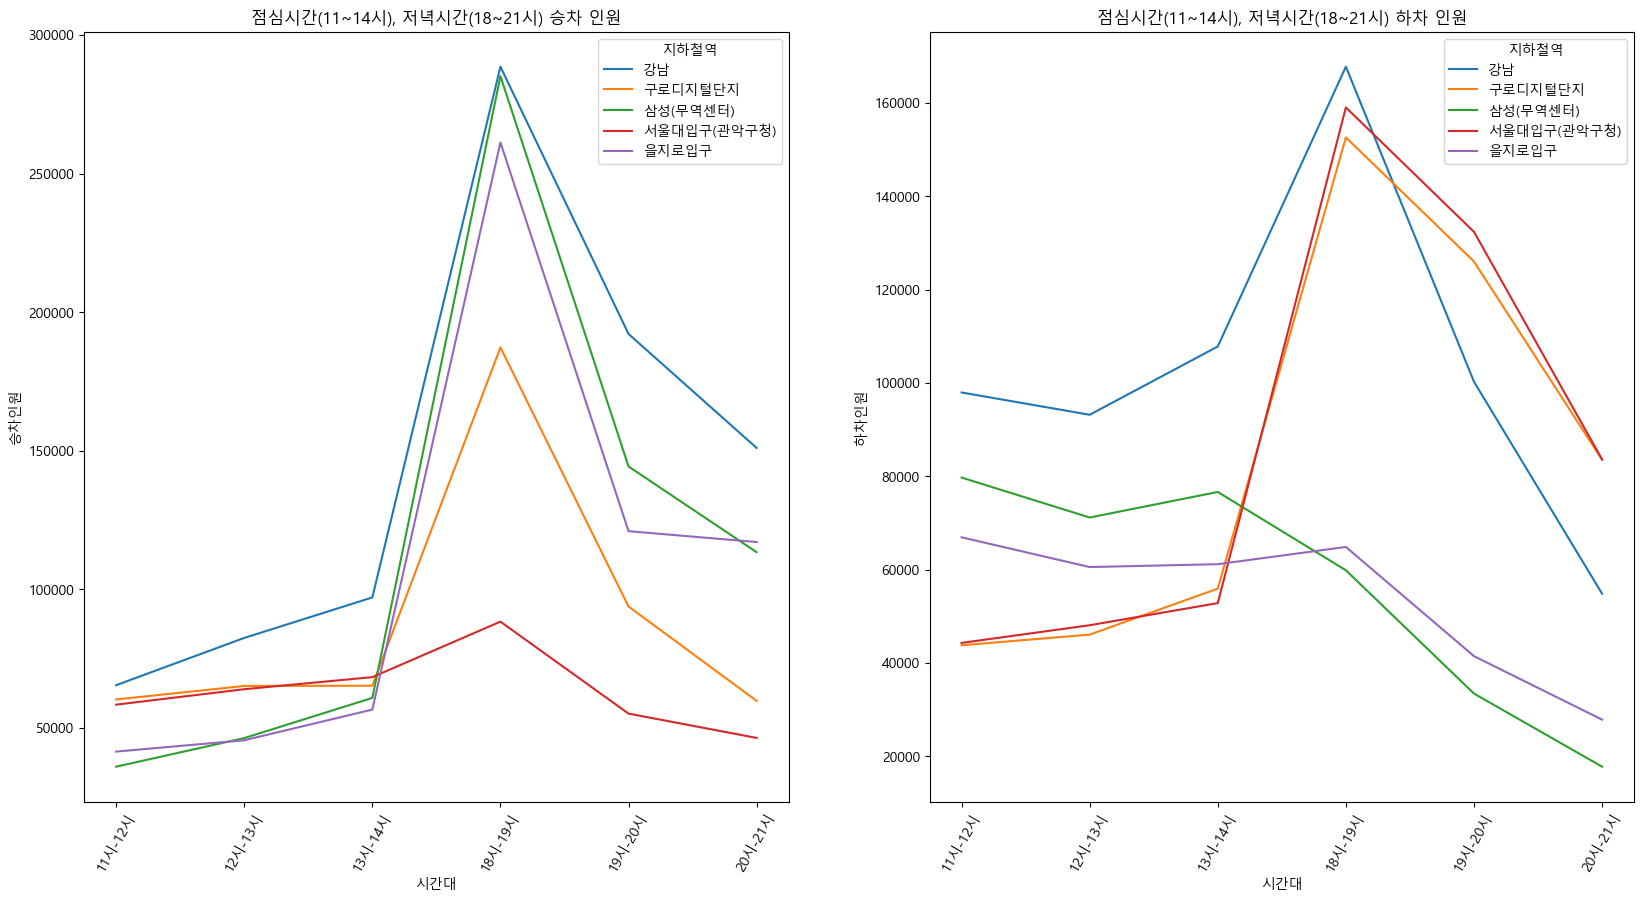

In [169]:
# 점심시간은 11시 ~ 14시, 그리고 저녁시간은 18시 ~ 21시 까지로 정한다.
time_columns = result.columns[16:22].append(result.columns[30:36])
take = result[time_columns[::2]].reset_index().melt(id_vars="지하철역",var_name='시간대', value_name='승차인원').applymap(
    lambda x: x.replace(' 승차인원', '') if isinstance(x, str) else x)
get_off = result[time_columns[1::2]].reset_index().melt(id_vars="지하철역",var_name='시간대', value_name='하차인원').applymap(
    lambda x: x.replace(' 하차인원', '') if isinstance(x, str) else x)

fig, axes = plt.subplots(1, 2, figsize=(20,10))


sns.lineplot(x='시간대', y='승차인원', hue='지하철역', data=take, ax=axes[0])
axes[0].set_xticklabels(take['시간대'].unique(), rotation=60)  # x축 라벨 회전
axes[0].set_title("점심시간(11~14시), 저녁시간(18~21시) 승차 인원")
sns.lineplot(x='시간대', y='하차인원', hue='지하철역', data=get_off, ax=axes[1])
axes[1].set_xticklabels(get_off['시간대'].unique(), rotation=60)  # x축 라벨 회전
axes[1].set_title("점심시간(11~14시), 저녁시간(18~21시) 하차 인원")

### 승차 인원 하차 인원 모두 점심시간 보다 저녁시간때에 더 많으며, 저녁시간 때에 승차 인원 대다수는 서울역에서 승차하며 하차 인원 대다수는 홍대 입구에서 내리는 것을 확인할 수 있었다.

# 인스타그램에 웨이팅 태그로 있는 맛집들의 분포는 어떻게 될까?

In [170]:
insta_post = pd.read_csv("./인스타그램 웨이팅 해시태그 연관 게시글.csv")
insta_post.head()

,게시글
0,대구 수성구 맛집 알아보다가 발견한 적돈 들안길점. 요즘 고기를 자주 먹으러 가는 ...
1,잠실 개나리아구찜 본점 웨이팅...\n.\n.\n.\n#핫플#핫플레이스#잠실#잠실맛...
2,웨이팅이 많아서 다음 기회에…후\n\n#노원맛집 #목고기집 #웨이팅 #노원구맛집 #...
3,오늘은 서울편\n\n아무리 그래도 새벽 한시반에 이런 웨이팅은 너무 한거 아니오??...
4,⠀\n바지락바지락...\n바지락이 어마어마하다\n바지락 까느라 웨이팅 생긴듯...\...


In [171]:
def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags if hashtags else None

# 'content' 열에 적용하여 해시태그 추출 후 새로운 열에 저장
insta_post['hashtags'] = insta_post['게시글'].apply(lambda x: extract_hashtags(x))

In [172]:
insta_post.dropna(inplace=True)
insta_post.head()

,게시글,hashtags
1,잠실 개나리아구찜 본점 웨이팅...\n.\n.\n.\n#핫플#핫플레이스#잠실#잠실맛...,"[#핫플, #핫플레이스, #잠실, #잠실맛집, #서울맛집, #잠실핫플, #서울핫플,..."
2,웨이팅이 많아서 다음 기회에…후\n\n#노원맛집 #목고기집 #웨이팅 #노원구맛집 #...,"[#노원맛집, #목고기집, #웨이팅, #노원구맛집, #상계맛집]"
3,오늘은 서울편\n\n아무리 그래도 새벽 한시반에 이런 웨이팅은 너무 한거 아니오??...,"[#성수감자탕, #감자탕, #웨이팅, #성수동, #성수동맛집, #소문난성수감자탕, ..."
4,⠀\n바지락바지락...\n바지락이 어마어마하다\n바지락 까느라 웨이팅 생긴듯...\...,"[#독산동, #구로디지털단지역, #순댕이네얼큰수제비, #순댕이네, #바지락, #칼국..."
5,"🎎오픈하자마자 바로 웨이팅 생기는 샤로수길 하이볼바 ""삐딱"" 대령하옵니다.\n#샤로...","[#샤로수길술집, #삐딱, #샤로수길맛집, #샤로수길술집, #샤로수길핫플, #샤로수..."


In [173]:

text = ""
for i in insta_post['hashtags']:
    text += ','.join(i).replace(",",'')

text


'#핫플#핫플레이스#잠실#잠실맛집#서울맛집#잠실핫플#서울핫플#잠실데이트#서울데이트#웨이팅#웨이팅맛집#핫플#데이트#데이트코스#치즈#볶음밥#좋아요#추천#좋반#봄#맞팔#선팔#먹방#먹스타그램#노원맛집#목고기집#웨이팅#노원구맛집#상계맛집#성수감자탕#감자탕#웨이팅#성수동#성수동맛집#소문난성수감자탕#성수동맛집#독산동#구로디지털단지역#순댕이네얼큰수제비#순댕이네#바지락#칼국수#수제비#칼제비#얼큰칼제비#매워#육수#단무지#웨이팅#해장#주말#혼밥#혼밥러#혼밥스타그램#먹스타그램#맛스타그램#순댕이네얼큰수제비오형#파워인스타글래머#샤로수길술집#삐딱#샤로수길맛집#샤로수길술집#샤로수길핫플#샤로수길맛집추천#서울대입구역맛집#서울대입구역#서울대입구술집#샤로수길데이트#샤로수길하이볼바#하이볼바#서울대입구하이볼#안주맛집#샤로수길안주맛집#안주맛집추천#하이볼맛집#웨이팅맛집#샤로수길핫플술집#웨이팅#바다회사랑#바다회사랑2호점#대방어#대방어맛집#홍대맛집#연남동맛집#566라멘#하쿠텐#하쿠텐라멘#하쿠텐x566라멘#콜라보#함께라멘데이#하카타돈코츠라멘#하카타돈코츠#돈코츠라멘#차슈멘#차슈#삼겹차슈#이벤트라멘#라멘포토카드#웨이팅#좋아요#맛집#맛집탐방#맛집추천#먹스타그램#맛집스타그램#을지로#을지로맛집#을지오뎅#도루묵#황태구이#오뎅바#낮에도#웨이팅#있네요#성수#서울숲#난포#한식#퓨전한식#맛집#맛#데이트#웨이팅#성수난포#호족반#범스푼_압구정#김진호호떡#붕어빵#호떡#국화빵#오뎅#호빵#생활의달인#남대문#남대문시장#꿀호떡#간식#간식맛집#웨이팅#웨이팅맛집#생활의달인맛집#간식스타그램#먹스타#먹스타그램#좋아요#선팔#맞팔#선팔환영#소통해요#소통#먹소통#안국역#핫플#라멘맛집#도마유즈라멘#라멘#웨이팅#먹스타#먹스타그램#맛스타그램#food#jmt#lamen#내돈내산#소점#오코노미야끼#핫쵸#타코야끼#히로시마풍오코노미야키#야끼소바빵#맥스생맥주#웨이팅#조앤도슨#지난피드#윤밀원#분당맛집#족발맛집#먹을텐데맛집#성시경맛집#아쉽#웨이팅#먹을텐데#나오지말지#클로이맛집_분당#압구정#더플디#슈크림#압구정카페#디저트맛집#빵맛집#압구정맛집#디저트#크림가득#소금빵#감

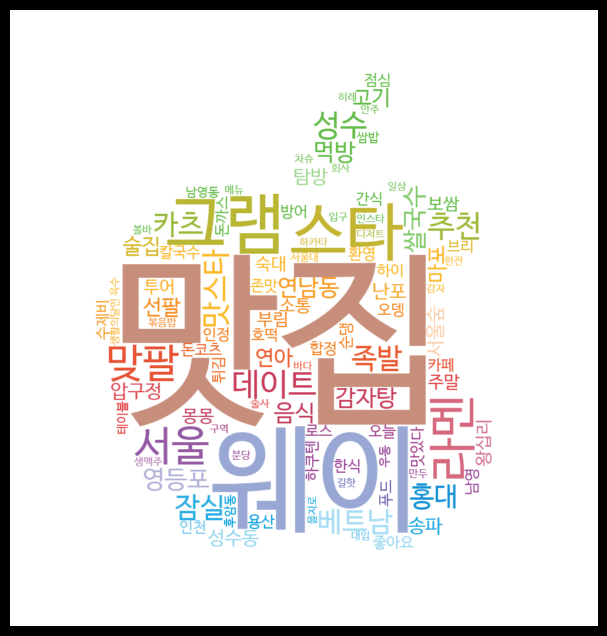

In [174]:
generate_wordcloud(text,'apple')

In [175]:
tabling_review = pd.read_csv("./테이블링어플 리뷰.csv")
tabling_review

,평점,리뷰
0,5,리뷰 없음
1,1,리뷰 없음
2,2,5일 업데이트 전까지는 별 5개 드릴 수 있을만큼 잘 쓰고있었는데 갑자기 웬 연돈 ...
3,5,이거 너무 좋은 데 외국분들도 사용가능하게 만들어 주시면 이회사가 더크게 발전하지 ...
4,1,앱 업데이트 하고 최악의 앱이 되었네요^^;; 원격 줄서기 하려면 테이블링페이가 필...
...,...,...
1094,1,쓰레기앱
1095,1,쓰레기앱
1096,1,垃圾앱
1097,5,조~~~~~~~타


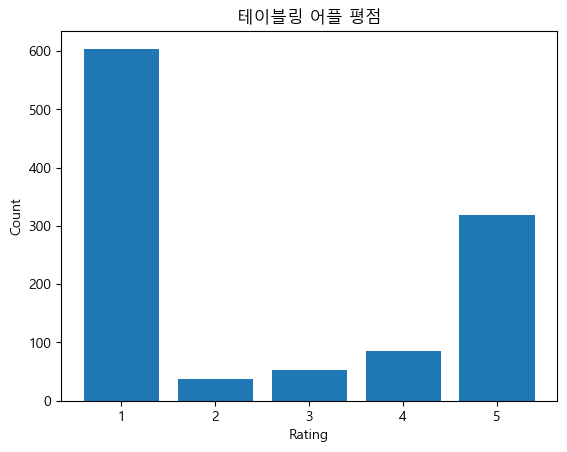

In [176]:
rating = tabling_review['평점'].value_counts().sort_index()

plt.bar(rating.index, rating.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('테이블링 어플 평점')
plt.show()

### 평점이 높을수록 좋은데 1점 평점이 지배적으로 많았다. 그러면 리뷰의 경우는 어떤 내용이 주를 이뤘을까?

In [177]:
# 구글 플레이스토어 어플리케이션 리뷰가 만약에 없을 경우 리뷰 없음 이라고 나와 있다.

tabling_review = tabling_review[tabling_review['리뷰'] != '리뷰 없음']
text = ','.join(tabling_review['리뷰']).replace(',','')
text

'5일 업데이트 전까지는 별 5개 드릴 수 있을만큼 잘 쓰고있었는데 갑자기 웬 연돈 메뉴 선택 기능을 예약 중간에 하도록 만드신건지 모르겠네요;; 가뜩이나 1초도 아닌 미리초단위로 성공 여부가 갈리고 인원 많을수록 예약하기 힘든데 4인의 경우 메뉴 선택하는데 누르는 시간 때문에 더 힘들어지겠네요. 그리고 이미 이전에도 기본메뉴 세팅이 되어있었고 변경을 희망하는 사람만 별도입력해서 하면 됐었는데 왜 이렇게 예약하기 번거롭게 바꾸신건지 이해가 안됩니다. 그냥 이전처럼 메뉴 선택 기능 없애주시거나 차라리 공정하게 메뉴칸도 인원수별로 반반 해서 별도로 수정하거나 누르지 않고도 바로 예약할 수 있도록 미리 세팅값을 설정해주셨으면 좋겠어요. 운영자님 이 글 보시면 부디 꼭 좀 의견 반영 부탁드립니다.이거 너무 좋은 데 외국분들도 사용가능하게 만들어 주시면 이회사가 더크게 발전하지 않을까요?? 요즘 사람많고 큰음식점을 많이 다녔는 데 다 테이블링이 있더군요 근데 (영어권.중국어.일본어)하시는 분은 테이블링 몰라서 그냥 서계시는 데 카톡이 있어야 테이블링이 되는 거라 설명해줘도 못하는 분들이 계시더군요 다이소 셀프 계산대도 영미일 버튼 터치 수 혼자서 잘하시던데 외국분들도 테이블링할수 있게 (영.중.일)버전도 만들어 보는 건 어떨까 합니다앱 업데이트 하고 최악의 앱이 되었네요^^;; 원격 줄서기 하려면 테이블링페이가 필수고 테이블링페이 하려면 아시다시피 계좌정보 등록해야하는데 과연 테이블링 앱에 이정도의 정보를 제공해야 할 가치가 있는지...? 저는 그냥 아침 일찍 일어나서 그냥 물리적으로 이동해서 줄서기 하고 말렵니다 차라리ㅎㅎ 정말 수익성 모델을 이렇게 짜는게 최선이셨나요...ㅎ 심지어 업데이트 후 리얼타임으로 줄서기 현황 보는 화면도 UI가 정말 혁명적으로 구려져서 놀라울 정도입니다ㅎ5일 업데이트 전까지는 별 5개 드릴 수 있을만큼 잘 쓰고있었는데 갑자기 웬 연돈 메뉴 선택 기능을 예약 중간에 하도록 만드신건지 모르겠네요;; 가뜩이나 1초도 아닌 미리초단위로 성공 여부

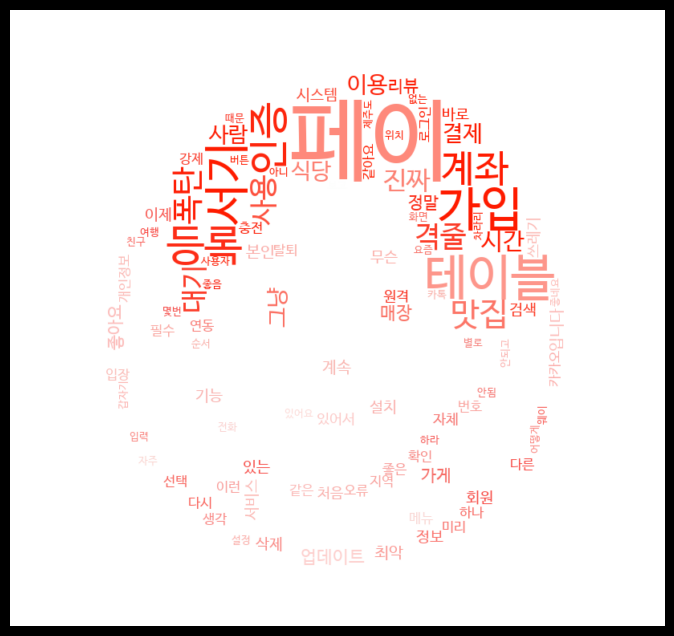

In [178]:
generate_wordcloud(text,"tabling")

### 웨이팅문제를 해소함과 동시에 어떻게하면 주변 상권도 활성화 시킬 수 있을까?

- 가급적 해당 문제를 컴퓨터를 이용해서 해결하는 것으로 생각해보았다.

- 지난 코로나19 유행기간 동안에 백신 예방접종을 돕기 위해서 카카오지도, 네이버지도 에서는 백신 예약이 가능한 병원의 잔여백신을 표시하는 기능이 있었다. 그리고 실제로 어플리케이션 내에 잔여백신이 남아 있는 병원이 있다면, 해당 병원을 클릭하면 바로 예약도 할 수 있는 기능 또한 있었다.

- 오픈소스 중 YOLO 라고 Object Detection 모델이 있었고 이를 통해서 매장 내에 있는 고객들의 수와, 식당 내 수용가능 인원을 비교해서 꽉차 있거나 웨이팅이 있을 경우 해당 상태를 지도에 표기를 하는 것을 제안해본다.

- 가게를 방문하기전 가게의 상태를 보고 웨이팅이 있거나, 가게가 많이 혼잡할 경우 다른 대안을 생각할 수 있을 것이다. 웨이팅은 고객들에게 그렇게 좋은 것도 아니고, 가게 점주의 입장에서도 부담스러운 것은 사실이다. 이를 해소함과 동시에, 주변의 식당들이 옵션으로 들어감에 따라 주변 상권의 활성화도 기대해볼 수 있을 것이다.